In [31]:
import numpy as np
import pandas as pd
import pymc3 as pm
import arviz as az
import matplotlib.pyplot as plt
%matplotlib inline

import wisps
import astropy.units as u
from astropy.coordinates import SkyCoord

In [32]:
#read-in the pointings
pnts=pd.read_pickle(wisps.OUTPUT_FILES+'/pointings.pkl')

#print (pnts[0].survey)
COORDS=SkyCoord([p.coord for p in pnts ])
galc=COORDS.transform_to('galactic')

LBS=np.vstack([[x.coord.galactic.l.radian,x.coord.galactic.b.radian] for x in pnts ])

LS=galc.l.radian
BS=galc.b.radian

In [33]:
pm.__version__

'3.9.3'

In [34]:
h=300

In [35]:
def density_function(r, z, h=300.):
    
    """
    A custom density 
    """
    l = 2600.
    zpart=np.exp(-abs(z-27)/h)
    rpart=np.exp(-(r-8300)/l)
    return zpart*rpart

def logp(l, b, r, z, d, h):
    return np.log((d**2)*density_function(r, z, h))

with pm.Model() as model:
    l=pm.Uniform('l', lower=-2*np.pi, upper=2*np.pi, testval=np.pi/2, observed=LS)
    b=pm.Uniform('b', lower=-2*np.pi, upper=2*np.pi, testval=np.pi/3, observed=BS)
    d=pm.Uniform('d', lower=0., upper=6000, testval=500.)

    x=pm.Deterministic('x',  8300-d*np.cos(b)*np.cos(l))
    y=pm.Deterministic('y', -d*np.cos(b)*np.sin(l))
    r=pm.Deterministic('r', (x**2+y**2)**0.5 )
    z=pm.Deterministic('z', 27+ d * np.sin(b))

    like = pm.Potential('likelihood', logp(l, b, r, z, d, h))# observed={'l':l, 'b':b,
                         #'r': r, 'z': z, 'd':d, 'h':h})
        
    trace = pm.sample(draws=1000, cores=4)

    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [d]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 28 seconds.


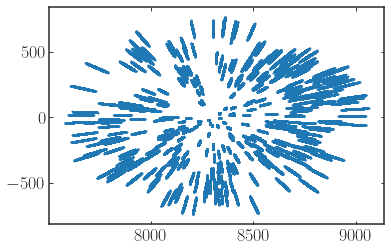

In [37]:
plt.scatter(trace['x'],trace['y'], s=1)

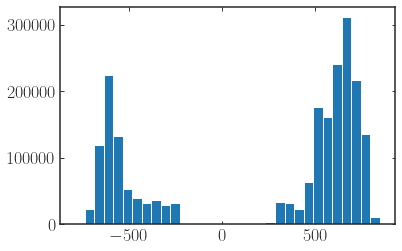

In [45]:
h=plt.hist(trace.z.flatten(), bins=32)

In [28]:
pm.model_graph.model_to_graphviz(model)

ImportError: This function requires the python library graphviz, along with binaries. The easiest way to install all of this is by running

	conda install -c conda-forge python-graphviz